# Exploration 2-1

### Wine Classification

### Table of Contents

1. Problem Definition
2. EDA
    - Missing value check
    - Data Distribution
        - Univariate Variable Visualization
    - Outlier Detection 
    - Data Imbalance
    - Correlation
3. Model Training
4. Model Evaluation & Summary

## 1. 문제 정의 (Problem Definition)
------

#####  주어진 시애틀 집값 데이터를  학습하여 해당 id가 가진 집값(price)를 예측하는 회귀 모형 구축

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings 
warnings.filterwarnings('ignore') # warning 무시

# Data Access
import os
from os.path import join

# Data Handling
import pandas as pd
import numpy as np

# Null Check
import missingno as msno

# ML Model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:,.2f}'.format

In [3]:
# 데이터 읽기
file_path = '2019-2nd-ml-month-with-kakr'
data_path = os.path.join('/content/drive/MyDrive', file_path)

train = pd.read_csv(data_path + '/train.csv')
test = pd.read_csv(data_path + '/test.csv')
sample_submission = pd.read_csv(data_path + '/sample_submission.csv' )

In [4]:
# 데이터체크
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [5]:
train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,"221,900.00",3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,1,20150225T000000,"180,000.00",2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
2,2,20150218T000000,"510,000.00",3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503
3,3,20140627T000000,"257,500.00",3,2.25,1715,6819,2.00,0,0,3,7,1715,0,1995,0,98003,47.31,-122.33,2238,6819
4,4,20150115T000000,"291,850.00",3,1.50,1060,9711,1.00,0,0,3,7,1060,0,1963,0,98198,47.41,-122.31,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,"610,685.00",4,2.50,2520,6023,2.00,0,0,3,9,2520,0,2014,0,98056,47.51,-122.17,2520,6023
15031,15031,20150326T000000,"1,007,500.00",4,3.50,3510,7200,2.00,0,0,3,9,2600,910,2009,0,98136,47.55,-122.40,2050,6200
15032,15032,20140521T000000,"360,000.00",3,2.50,1530,1131,3.00,0,0,3,8,1530,0,2009,0,98103,47.70,-122.35,1530,1509
15033,15033,20150223T000000,"400,000.00",4,2.50,2310,5813,2.00,0,0,3,8,2310,0,2014,0,98146,47.51,-122.36,1830,7200


In [6]:
test

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.00,0,0,3,11,3890,1530,2001,0,98053,47.66,-122.00,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.00,0,0,3,7,1050,730,1960,0,98146,47.51,-122.34,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.00,0,0,3,7,1890,0,2003,0,98038,47.37,-122.03,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,20140626T000000,3,1.75,1500,11968,1.00,0,0,3,6,1500,0,2014,0,98010,47.31,-122.00,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.00,0,0,3,8,1490,0,2014,0,98144,47.57,-122.29,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.00,0,0,3,8,1180,130,2008,0,98116,47.58,-122.41,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.00,0,0,3,7,1020,0,2009,0,98144,47.59,-122.30,1020,2007


1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

### 주관적인 특성 해석

1. 집값과 비례 관계를 가지는 특성(예측에 중요한 영향을 줄 것으로 예상)

- bedrooms : 방이 많으면 비싸다
- bathrooms : 화장실이 많으면 비싸다
- sqft_living : 한국에서 전용면적으로 생각.... 넓으면 비싸다(1)
- sqft_lot : 한국에서 대지지분으로 생각....  넓으면 비싸다(2)
- floors : 저층보다 고층이 보통 가격이 높다
- waterfront : 한국에서 한강뷰가 비싼것처럼...
- view : 좋아보이는 집은 비싸다
- grade :  King County grading의 기준은 모르지만 높으면 좋을 것 같다.
- sqft_above : 넓으면 비싸다(3)
- sqrt_basement : 지하실까지 있으면 더 비싸다.. 넓으면 비싸다(4)
- yr_renovated : 재건축을 했다면 가격이 비싸진다.
- sqft_living15 : 넓으면 비싸다(5)
- sqft_lot15 : 넓으면 비싸다(6)


2. 비례인지 반비례인지 애매한 특성

- yr_built : 구축은 신축에 비해 가격이 저렴한데 한국의 경우 30년 이상된 재건축 가능한 집은 비싸다. 미국의 상황은 잘 모르고 일단 그래프를 통해 확인하니 뚜렷한 패턴을 보이지 않으므로 중요한 특성은 아닐 것 같다.

3. 당장은 예측에 아무런 정보가 되지 못하는 특성 (이 정보를 활용하면 유용한 정보를 만들 수 있을 것 같다.)

- date : 날짜 정보를 어떻게 활용할 수 있을까?
- zipcode, lat, long : 공간, 지리적 정보를 어떻게 활용할 수 있을까?

4. 필요없는 특성
- id : 예측에 사용하지 않을 것

In [7]:
# id column 저장
train_id = train['id']
test_id = test['id']

# 예측에 사용하지 않을 것이므로 id 컬럼을 제거
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,"221,900.00",3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,20150225T000000,"180,000.00",2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
2,20150218T000000,"510,000.00",3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503
3,20140627T000000,"257,500.00",3,2.25,1715,6819,2.00,0,0,3,7,1715,0,1995,0,98003,47.31,-122.33,2238,6819
4,20150115T000000,"291,850.00",3,1.50,1060,9711,1.00,0,0,3,7,1060,0,1963,0,98198,47.41,-122.31,1650,9711


Data Processing

Outliers

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  object 
 1   price          15035 non-null  float64
 2   bedrooms       15035 non-null  int64  
 3   bathrooms      15035 non-null  float64
 4   sqft_living    15035 non-null  int64  
 5   sqft_lot       15035 non-null  int64  
 6   floors         15035 non-null  float64
 7   waterfront     15035 non-null  int64  
 8   view           15035 non-null  int64  
 9   condition      15035 non-null  int64  
 10  grade          15035 non-null  int64  
 11  sqft_above     15035 non-null  int64  
 12  sqft_basement  15035 non-null  int64  
 13  yr_built       15035 non-null  int64  
 14  yr_renovated   15035 non-null  int64  
 15  zipcode        15035 non-null  int64  
 16  lat            15035 non-null  float64
 17  long           15035 non-null  float64
 18  sqft_l

In [9]:
numerical_feature_list = list(train.dtypes[train.dtypes != 'object'].index)

In [10]:
print(numerical_feature_list)

['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


In [11]:
removed_feature_list = ['price', 'bedrooms','bathrooms','floors','view','condition','grade','zipcode','waterfront','yr_renovated']
numerical_feature_list = [i for i in numerical_feature_list if i not in removed_feature_list]
print(numerical_feature_list)

['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


In [12]:
def show_scatter(feature_list, i, j):
    plt.figure(figsize=(20,5))
    idx = 1
    for feature in feature_list:
        if idx <= (i * j):
            plt.subplot(i, j, idx)
            plt.scatter(x=train[feature], y=train['price'])
            plt.xlabel(feature, fontsize=13)
            plt.ylabel('price', fontsize=13)
            plt.xticks([])
            idx += 1
        else:
            break
    plt.show()

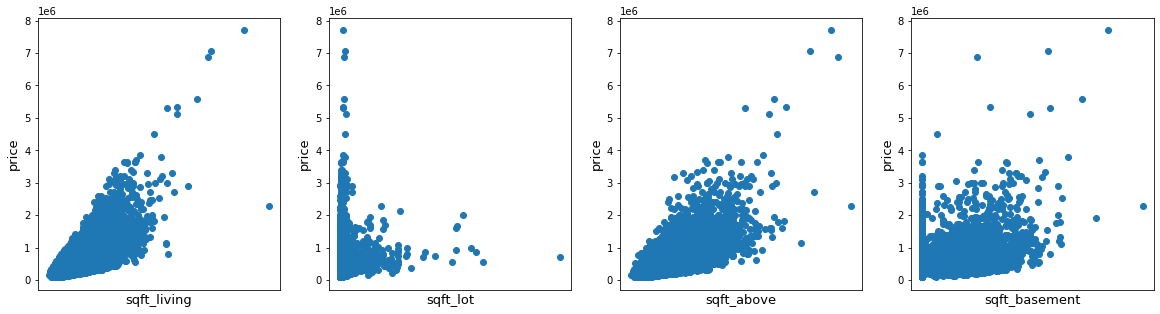

In [13]:
show_scatter(numerical_feature_list[:4], 1, 4)

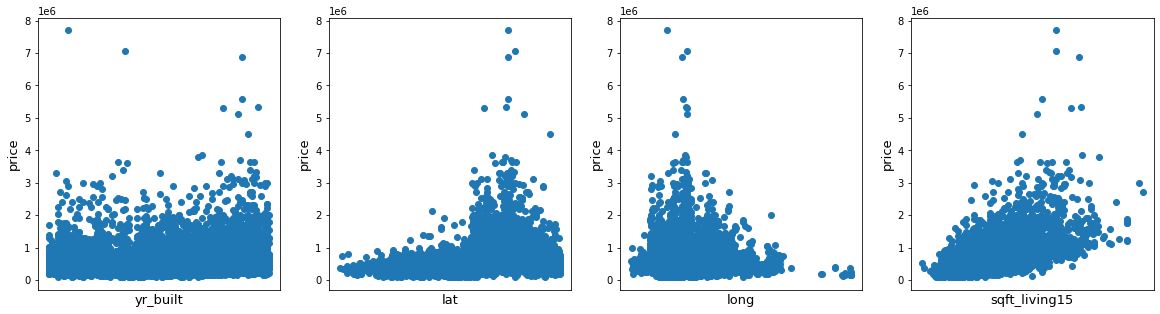

In [14]:
show_scatter(numerical_feature_list[4:8], 1, 4)

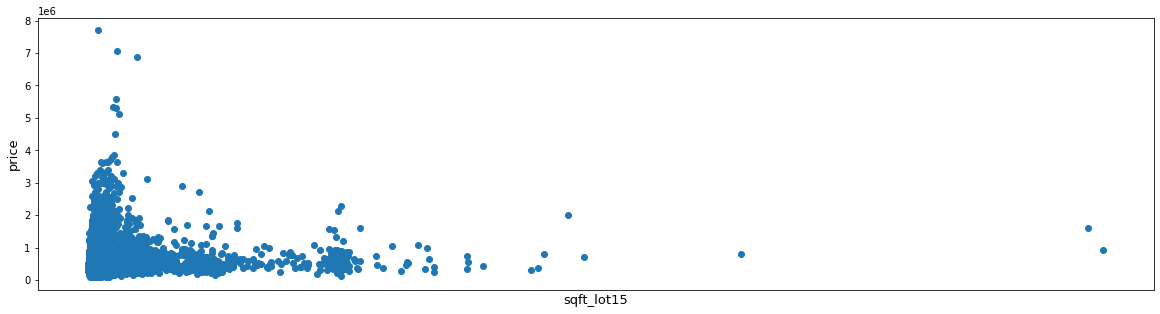

In [15]:
show_scatter(numerical_feature_list[8:], 1, 1)

In [16]:
from scipy import stats
from scipy.stats import norm, skew

mu : 540682.6531426671, sigma : 371512.3048586903


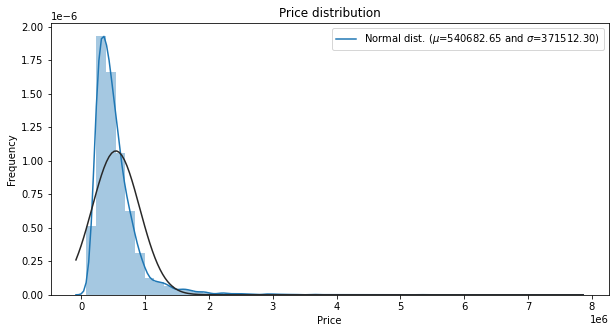

In [17]:
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['price'])
print(f"mu : {mu}, sigma : {sigma}")


# 분포를 그래프에 그려봅시다
plt.figure(figsize=(10,5))
sns.distplot(train['price'], fit=norm)
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.title('Price distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

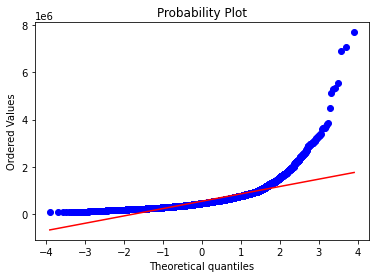

In [18]:
# QQ-plot을 그려봅시다.
fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()

mu : 13.04812230186611, sigma : 0.5274533608586434


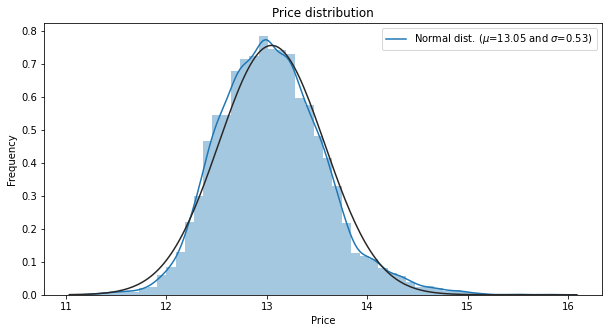

In [19]:
train['price'] = np.log1p(train['price'])

(mu, sigma) = norm.fit(train['price'])
print(f"mu : {mu}, sigma : {sigma}")

# 위에서와 같은 코드로 똑같이 분포를 확인해봅니다.
plt.figure(figsize=(10,5))
sns.distplot(train['price'], fit=norm)
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.title('Price distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

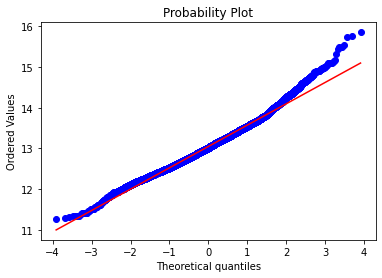

In [20]:
# QQ-plot을 그려봅시다.
fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()

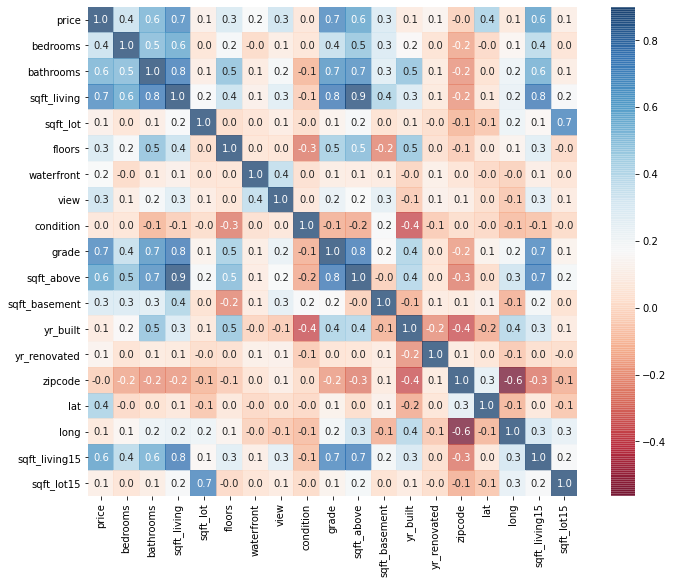

In [21]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True, cmap='RdBu', alpha=0.7, annot=True,fmt='3.1f')
plt.show()

In [22]:
corrmat['price'].sort_values(ascending=False)

price            1.00
grade            0.71
sqft_living      0.70
sqft_living15    0.62
sqft_above       0.61
bathrooms        0.55
lat              0.44
bedrooms         0.36
view             0.35
floors           0.32
sqft_basement    0.31
waterfront       0.17
yr_renovated     0.13
sqft_lot         0.11
sqft_lot15       0.10
yr_built         0.08
long             0.05
condition        0.04
zipcode         -0.04
Name: price, dtype: float64

![image.png](attachment:image.png)

In [23]:
train[['lat','long']]

,lat,long
0,47.51,-122.26
1,47.74,-122.23
2,47.62,-122.05
3,47.31,-122.33
4,47.41,-122.31
...,...,...
15030,47.51,-122.17
15031,47.55,-122.40
15032,47.70,-122.35
15033,47.51,-122.36


In [24]:
# A. Haversine Distance Between the Two Lat/Lons:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [25]:
# B. Manhattan Distance Between the two Lat/Lons:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

In [26]:
# C. Bearing Between the two Lat/Lons:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [27]:
# train
train['haversine_array'] = train[['lat','long']].apply(lambda x: haversine_array(x['lat'], x['long'], 47.60814, -122.33388), axis=1)
train['dummy_manhattan_distance'] = train[['lat','long']].apply(lambda x: dummy_manhattan_distance(x['lat'], x['long'], 47.60814, -122.33388), axis=1)
train['bearing_array'] = train[['lat','long']].apply(lambda x: bearing_array(x['lat'], x['long'], 47.60814, -122.33388), axis=1)

# test
test['haversine_array'] = test[['lat','long']].apply(lambda x: haversine_array(x['lat'], x['long'], 47.60814, -122.33388), axis=1)
test['dummy_manhattan_distance'] = test[['lat','long']].apply(lambda x: dummy_manhattan_distance(x['lat'], x['long'], 47.60814, -122.33388), axis=1)
test['bearing_array'] = test[['lat','long']].apply(lambda x: bearing_array(x['lat'], x['long'], 47.60814, -122.33388), axis=1)

In [28]:
def show_scatter(feature_list, i, j):
    plt.figure(figsize=(20,10))
    idx = 1
    for feature in feature_list:
        if idx <= (i * j):
            plt.subplot(i, j, idx)
            plt.scatter(x=train[feature], y=train['price'])
            plt.xlabel(feature, fontsize=13)
            plt.ylabel('price', fontsize=13)
            plt.xticks([])
            idx += 1
        else:
            break
    plt.show()

In [29]:
comparison_list = ['lat', 'long', 'haversine_array','dummy_manhattan_distance','bearing_array']

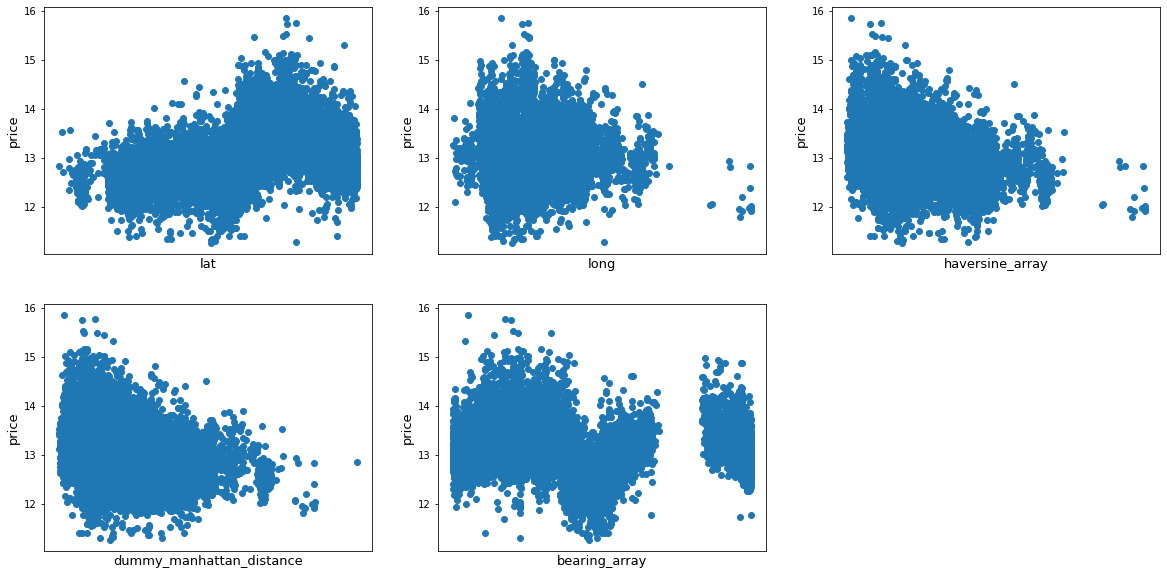

In [30]:
show_scatter(comparison_list, 2, 3)

In [31]:
corrmat_with_distance = train[['price','lat','long','haversine_array','dummy_manhattan_distance','bearing_array']].corr()

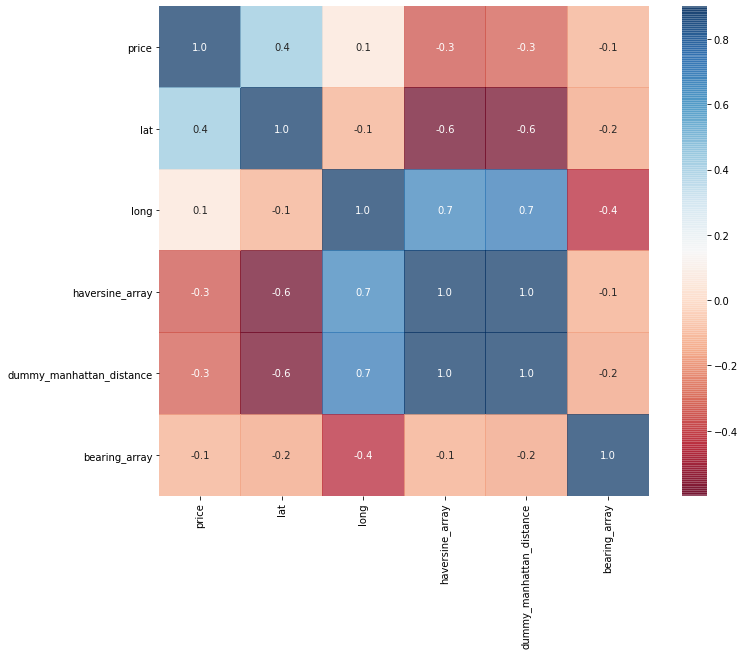

In [32]:
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat_with_distance, vmax=0.9, square=True, cmap='RdBu', alpha=0.7, annot=True,fmt='3.1f')
plt.show()

In [33]:
corrmat_with_distance

,price,lat,long,haversine_array,dummy_manhattan_distance,bearing_array
price,1.00,0.44,0.05,-0.35,-0.33,-0.13
lat,0.44,1.00,-0.13,-0.60,-0.58,-0.16
long,0.05,-0.13,1.00,0.67,0.70,-0.44
haversine_array,-0.35,-0.60,0.67,1.00,0.98,-0.15
dummy_manhattan_distance,-0.33,-0.58,0.70,0.98,1.00,-0.17
bearing_array,-0.13,-0.16,-0.44,-0.15,-0.17,1.00


In [34]:
y_train = train.price.values

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['price'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (21503, 22)


<Figure size 1080x576 with 0 Axes>

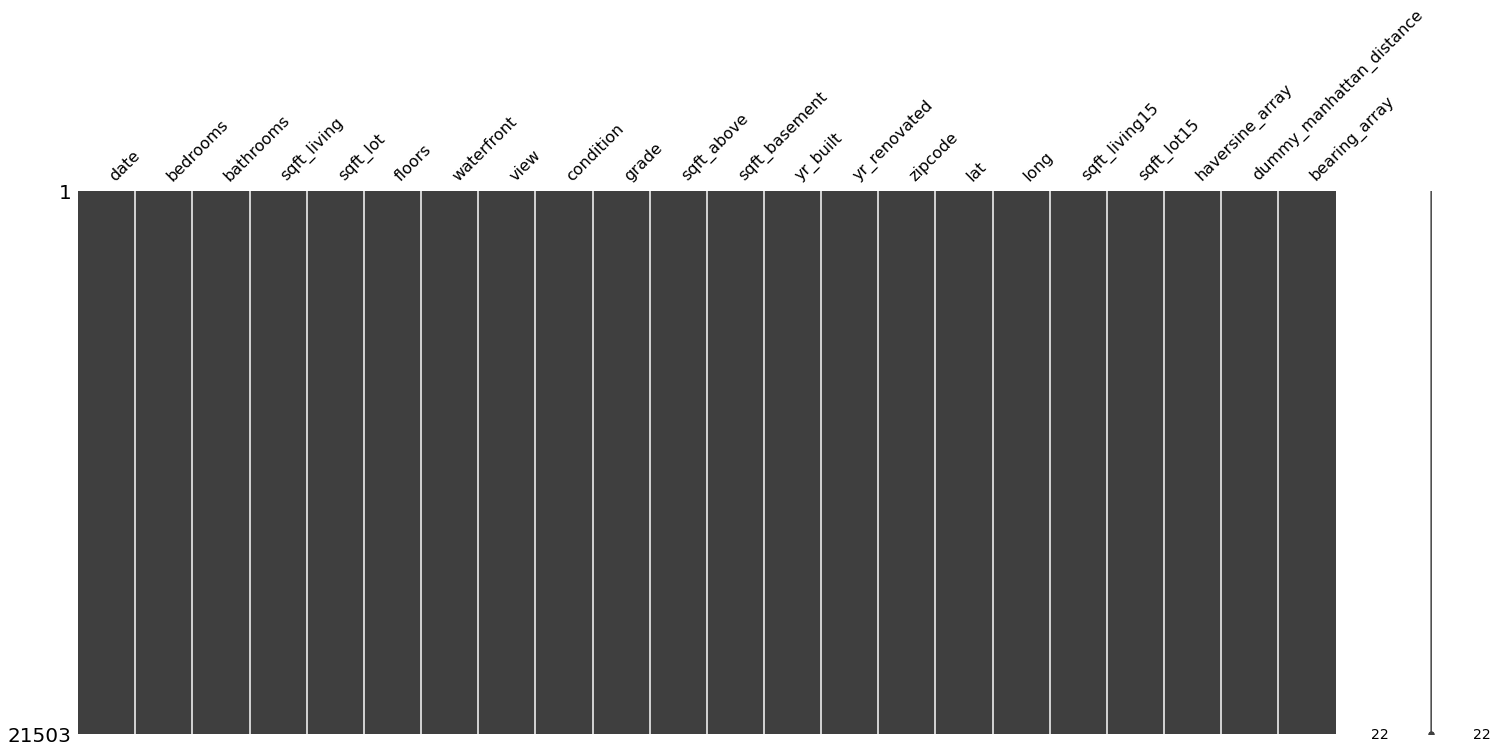

In [35]:
plt.figure(figsize=(15,8))
msno.matrix(all_data)
plt.show()

In [36]:
# Percent missing data by feature
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)

missing_data = pd.DataFrame({"Missing Ratio" : all_data_na})
missing_data

,Missing Ratio


In [37]:
# str(x[:6]) 으로 처리한 것은 20141013T000000 형식의 데이터를 
# 연/월 데이터만 사용하기 위해 201410까지 자르기 위한 것입니다.
all_data.drop(['date'], axis=1, inplace=True)
all_data.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,haversine_array,dummy_manhattan_distance,bearing_array
0,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650,12.23,16.55,-28.13
1,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062,16.29,21.97,-152.33
2,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503,21.68,22.62,-92.44
3,3,2.25,1715,6819,2.00,0,0,3,7,1715,0,1995,0,98003,47.31,-122.33,2238,6819,33.19,33.70,-0.89
4,3,1.50,1060,9711,1.00,0,0,3,7,1060,0,1963,0,98198,47.41,-122.31,1650,9711,22.13,23.51,-3.67


In [38]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21503 entries, 0 to 21502
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bedrooms                  21503 non-null  int64  
 1   bathrooms                 21503 non-null  float64
 2   sqft_living               21503 non-null  int64  
 3   sqft_lot                  21503 non-null  int64  
 4   floors                    21503 non-null  float64
 5   waterfront                21503 non-null  int64  
 6   view                      21503 non-null  int64  
 7   condition                 21503 non-null  int64  
 8   grade                     21503 non-null  int64  
 9   sqft_above                21503 non-null  int64  
 10  sqft_basement             21503 non-null  int64  
 11  yr_built                  21503 non-null  int64  
 12  yr_renovated              21503 non-null  int64  
 13  zipcode                   21503 non-null  int64  
 14  lat   

In [39]:
categorical_features = ['bedrooms','bathrooms','floors','view','condition','grade','zipcode','waterfront','yr_built', 'yr_renovated']

In [40]:
# type 변환
for feature in categorical_features:
    all_data[feature] = all_data[feature].apply(str)

In [41]:
all_data.dtypes

bedrooms                     object
bathrooms                    object
sqft_living                   int64
sqft_lot                      int64
floors                       object
waterfront                   object
view                         object
condition                    object
grade                        object
sqft_above                    int64
sqft_basement                 int64
yr_built                     object
yr_renovated                 object
zipcode                      object
lat                         float64
long                        float64
sqft_living15                 int64
sqft_lot15                    int64
haversine_array             float64
dummy_manhattan_distance    float64
bearing_array               float64
dtype: object

In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# process columns, apply LabelEncoder to categorical features
for feature in categorical_features:
    if feature == 'zipcode':
        continue
    enc = LabelEncoder() 
    all_data[feature] = enc.fit_transform(all_data[feature])
# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (21503, 21)


In [43]:
all_data = pd.get_dummies(all_data)

In [44]:
all_data

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,haversine_array,dummy_manhattan_distance,bearing_array,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,...,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,5,3,1180,5650,0,0,0,2,9,1180,0,55,0,47.51,-122.26,1340,5650,12.23,16.55,-28.13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,4,3,770,10000,0,0,0,2,8,770,0,33,0,47.74,-122.23,2720,8062,16.29,21.97,-152.33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5,7,1680,8080,0,0,0,2,10,1680,0,87,0,47.62,-122.05,1800,7503,21.68,22.62,-92.44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5,8,1715,6819,2,0,0,2,9,1715,0,95,0,47.31,-122.33,2238,6819,33.19,33.70,-0.89,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,5,1060,9711,0,0,0,2,9,1060,0,63,0,47.41,-122.31,1650,9711,22.13,23.51,-3.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,5,6,1500,11968,0,0,0,2,8,1500,0,114,0,47.31,-122.00,1320,11303,41.54,58.23,-36.80,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21499,5,7,1490,1126,4,0,0,2,10,1490,0,114,0,47.57,-122.29,1400,1230,5.47,7.69,-38.96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
21500,5,9,1310,1294,2,0,0,2,10,1180,130,108,0,47.58,-122.41,1330,1265,6.59,9.06,58.64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21501,4,2,1020,1350,2,0,0,2,9,1020,0,109,0,47.59,-122.30,1020,2007,3.03,4.14,-59.69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [45]:
all_data['sqft_total'] = all_data['sqft_above'] + all_data['sqft_basement']

In [46]:
numeric_features = ['sqft_living','sqft_lot','sqft_above','sqft_basement',
                    'sqft_living15','sqft_lot15','sqft_total']

In [47]:
def show_kdetplot(numeric_features, i, j):
    plt.figure(figsize=(20,20))
    idx = 1
    for feature in numeric_features:
        if idx < len(numeric_features):
            plt.subplot(i, j, idx)
            sns.kdeplot(all_data[numeric_features[idx]]).set_title("{}".format(feature))
            idx += 1
        else:
            break

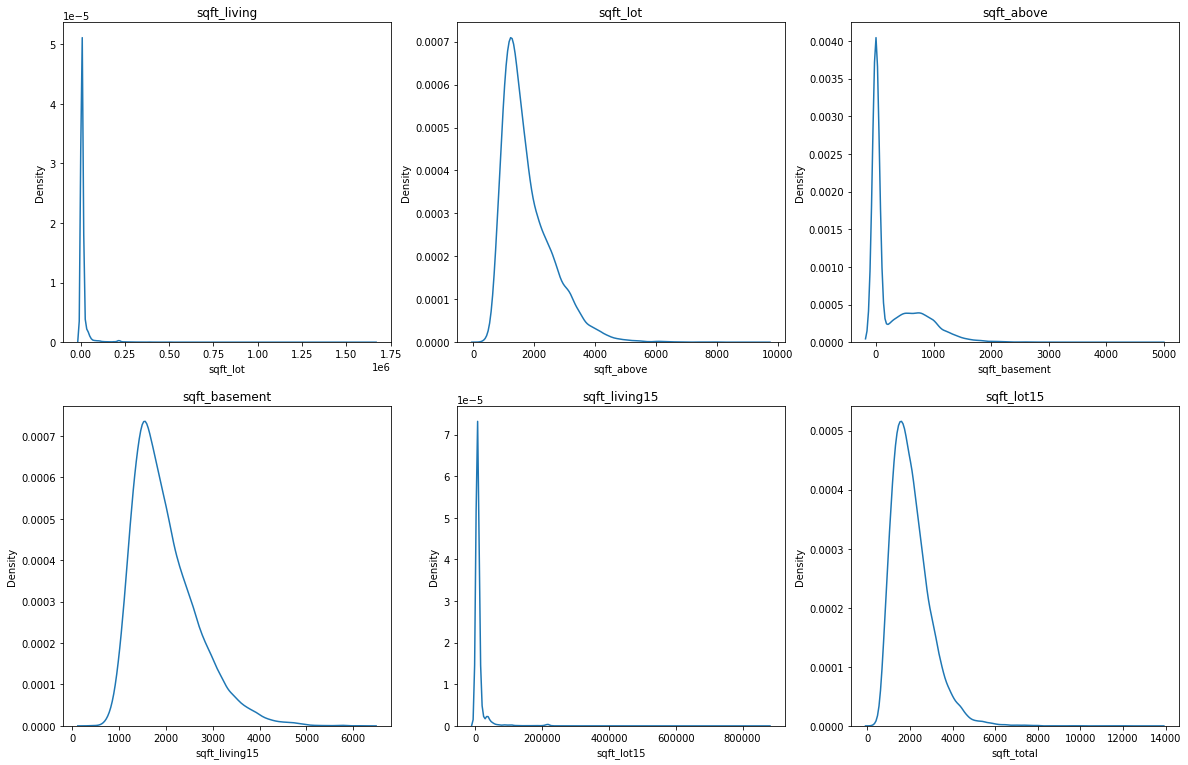

In [48]:
show_kdetplot(numeric_features,3,3)

In [49]:
# 수치형 데이터에서 skewness 체크
skewed_feats = all_data[numeric_features].apply(lambda x : skew(x.dropna())).sort_values(ascending=False)

print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
sqft_lot,13.06
sqft_lot15,9.51
sqft_basement,1.58
sqft_total,1.47
sqft_living,1.47
sqft_above,1.45
sqft_living15,1.11


In [50]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 7 skewed numerical features to Box Cox transform


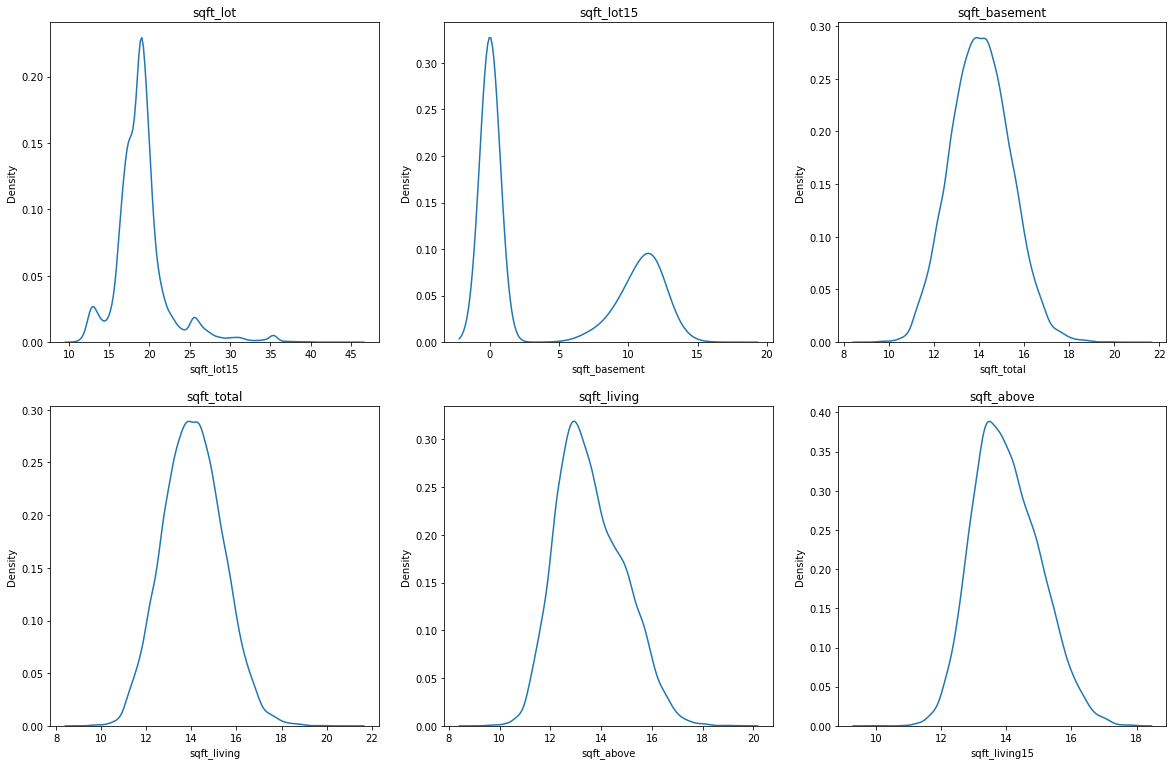

In [51]:
show_kdetplot(skewed_features,3,3)

In [52]:
skewed_feats = all_data[numeric_features].apply(lambda x : skew(x.dropna())).sort_values(ascending=False)

print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
sqft_lot,1.91
sqft_lot15,1.86
sqft_basement,0.54
sqft_above,0.41
sqft_living15,0.33
sqft_total,0.15
sqft_living,0.15


중공선성 제거'가 있습니다.

다중공선성 : 독립 변수간의 상관 관계가 강하게 나타나, 회귀분석에 악영향을 주는 경우

 

그럼 앞에서 언급했던 상관관계 분석을 통해 각 속성(독립변수) 사이의 상관 관계를 보겠습니다.

회귀 모델에서 다중공선성을 파악할 수 있는 대표적인 방법은 VIF입니다.

VIF (Variance inflation Factors 분산팽창요인)

안전 : VIF < 5

주의 : 5 < VIF < 10

위험 : 10 < VIF


수식은 위와 같은데, 여기서는 바로 넘어가겠습니다.

순서

1. VIF 계수가 높은 feature제거
2. 단 유사한 feature의 경우, 둘 중 1개만 제거(sqft_total, haversine_array의 경우)
3. 제거 후 VIF계수 재출력
4. (1, 2, 3)의 과정 반복
5. 회귀분석 진행
6. feature의 p-value점검

In [53]:
all_data

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,haversine_array,dummy_manhattan_distance,bearing_array,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,...,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,sqft_total
0,5,3,12.60,17.70,0,0,0,2,9,12.60,0.00,55,0,47.51,-122.26,12.97,17.70,12.23,16.55,-28.13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,12.60
1,4,3,11.40,19.87,0,0,0,2,8,11.40,0.00,33,0,47.74,-122.23,15.17,19.03,16.29,21.97,-152.33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.40
2,5,7,13.64,19.04,0,0,0,2,10,13.64,0.00,87,0,47.62,-122.05,13.86,18.75,21.68,22.62,-92.44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.64
3,5,8,13.71,18.39,2,0,0,2,9,13.71,0.00,95,0,47.31,-122.33,14.54,18.39,33.19,33.70,-0.89,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.71
4,5,5,12.29,19.76,0,0,0,2,9,12.29,0.00,63,0,47.41,-122.31,13.59,19.76,22.13,23.51,-3.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,12.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,5,6,13.30,20.60,0,0,0,2,8,13.30,0.00,114,0,47.31,-122.00,12.92,20.37,41.54,58.23,-36.80,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.30
21499,5,7,13.28,12.46,4,0,0,2,10,13.28,0.00,114,0,47.57,-122.29,13.10,12.72,5.47,7.69,-38.96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,13.28
21500,5,9,12.90,12.87,2,0,0,2,10,12.60,7.18,108,0,47.58,-122.41,12.95,12.80,6.59,9.06,58.64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.90
21501,4,2,12.18,12.99,2,0,0,2,9,12.18,0.00,109,0,47.59,-122.30,12.18,14.19,3.03,4.14,-59.69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,12.18


In [54]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [55]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 피처마다의 VIF 계수를 출력합니다.
all_data_corr = all_data.corr()
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(all_data_corr.values, i) for i in range(all_data_corr.shape[1])]
vif["features"] = all_data_corr.columns
vif.sort_values(by='VIF Factor', ascending=False)[70:]

,VIF Factor,features
35,inf,zipcode_98027
34,inf,zipcode_98024
17,"574,372.02",haversine_array
18,"551,975.92",dummy_manhattan_distance
13,"40,682.82",lat
14,"29,917.99",long
19,"20,990.83",bearing_array
9,"9,702.39",sqft_above
10,791.74,sqft_basement
16,228.05,sqft_lot15


In [56]:
train['sqft_total'] = all_data['sqft_total']
train.corr()['price'].sort_values(ascending=False)

price                       1.00
grade                       0.71
sqft_living                 0.70
sqft_total                  0.68
sqft_living15               0.62
sqft_above                  0.61
bathrooms                   0.55
lat                         0.44
bedrooms                    0.36
view                        0.35
floors                      0.32
sqft_basement               0.31
waterfront                  0.17
yr_renovated                0.13
sqft_lot                    0.11
sqft_lot15                  0.10
yr_built                    0.08
long                        0.05
condition                   0.04
zipcode                    -0.04
bearing_array              -0.13
dummy_manhattan_distance   -0.33
haversine_array            -0.35
Name: price, dtype: float64

In [57]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [58]:
def rmsle_cv(model, n_folds=5):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_df.values)
    rmse = np.sqrt(-cross_val_score(model, train_df.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return (rmse)

In [59]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
all_data = all_data.drop(['sqft_total'], axis=1)
train_df = all_data[:len(train)]
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1900 (0.0041)



In [60]:
# 피처마다의 VIF 계수를 출력합니다.
all_data_corr = all_data.corr()
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(all_data_corr.values, i) for i in range(all_data_corr.shape[1])]
vif["features"] = all_data_corr.columns
vif.sort_values(by='VIF Factor', ascending=False)[70:]

,VIF Factor,features
17,"573,123.51",haversine_array
18,"550,620.14",dummy_manhattan_distance
13,"70,254.68",lat
14,"29,446.54",long
19,"19,452.56",bearing_array
2,"11,017.52",sqft_living
9,"10,524.63",sqft_above
10,962.96,sqft_basement
16,221.96,sqft_lot15
3,214.13,sqft_lot


In [61]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
all_data = all_data.drop(['dummy_manhattan_distance'], axis=1)
train_df = all_data[:len(train)]
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1899 (0.0041)



In [62]:
# 피처마다의 VIF 계수를 출력합니다.
all_data_corr = all_data.corr()
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(all_data_corr.values, i) for i in range(all_data_corr.shape[1])]
vif["features"] = all_data_corr.columns
vif.sort_values(by='VIF Factor', ascending=False)[70:]

,VIF Factor,features
13,"36,234.16",lat
18,"22,556.83",bearing_array
17,"18,735.28",haversine_array
2,"10,987.89",sqft_living
9,"10,400.92",sqft_above
14,"6,129.56",long
10,924.43,sqft_basement
16,209.92,sqft_lot15
3,200.73,sqft_lot
15,172.81,sqft_living15


In [63]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
all_data = all_data.drop(['lat'], axis=1)
train_df = all_data[:len(train)]
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1895 (0.0043)



In [64]:
# 피처마다의 VIF 계수를 출력합니다.
all_data_corr = all_data.corr()
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(all_data_corr.values, i) for i in range(all_data_corr.shape[1])]
vif["features"] = all_data_corr.columns
vif.sort_values(by='VIF Factor', ascending=False)[70:]

,VIF Factor,features
13,"26,125.59",long
17,"24,299.54",bearing_array
2,"10,980.48",sqft_living
9,"10,399.67",sqft_above
16,"10,193.34",haversine_array
10,913.93,sqft_basement
15,208.21,sqft_lot15
3,199.40,sqft_lot
14,145.91,sqft_living15
1,75.27,bathrooms


In [65]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
all_data = all_data.drop(['bearing_array'], axis=1)
train_df = all_data[:len(train)]
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1894 (0.0043)



In [66]:
# 피처마다의 VIF 계수를 출력합니다.
all_data_corr = all_data.corr()
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(all_data_corr.values, i) for i in range(all_data_corr.shape[1])]
vif["features"] = all_data_corr.columns
vif.sort_values(by='VIF Factor', ascending=False)[70:]

,VIF Factor,features
13,"24,631.59",long
16,"11,572.32",haversine_array
2,"10,893.79",sqft_living
9,"10,294.20",sqft_above
10,912.55,sqft_basement
15,204.99,sqft_lot15
3,196.41,sqft_lot
4,110.52,floors
14,99.39,sqft_living15
11,83.12,yr_built


In [67]:
train_df = all_data[:len(train)]
test_df = all_data[len(train):]

In [68]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
ElasticNet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
Kernal_Ridge = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [69]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4,
                                   max_features='sqrt', min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

In [70]:
xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [71]:
lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [72]:
models = [{'model':lasso, 'name':'lasso'}, 
          {'model':ElasticNet, 'name':'ElasticNet'},
          {'model':Kernal_Ridge, 'name':'Kernal_Ridge'},
          {'model':xgb, 'name':'xgb'},
          {'model':GBoost, 'name':'GBoost'},
          {'model':lgb, 'name':'lgb'}]

In [73]:
for m in models:
    print("Model {} CV score : {:.4f}".format(m['name'], rmsle_cv(m['model']).mean()))

Model lasso CV score : 0.1894
Model ElasticNet CV score : 0.1888
Model Kernal_Ridge CV score : 0.1703
Model xgb CV score : 0.1631
Model GBoost CV score : 0.1621
Model lgb CV score : 0.1739


In [74]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

In [75]:
averaged_models = AveragingModels(models = (lasso, ElasticNet, Kernal_Ridge, GBoost))

score = rmsle_cv(averaged_models)
print("Averaged base models CV score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models CV score: 0.1699 (0.0060)



Less simple Stacking : Adding a Meta-model
이 방법은 meta model을 추가하고, base model들의 평균과 이 out-of-folds 예측을 이용하여 meta-model을 훈련시킵니다.

기본적인 흐름은 다음과 같습니다.

훈련 데이터를 분리된 데이터셋 train, holdout으로 나눕니다.
train 데이터로 훈련을 하고
holdout 데이터로 테스트 합니다.
3)을 통해 예측값을 구하고, meta model을 통해 그 예측 값으로 모델을 학습합니다.
첫 세 단계는 순서대로 진행하면 됩니다. 만약 5-fold stacking을 한다면, 5-folds를 예시로 들어봅니다.

그렇다면 훈련 데이터를 5개로 나누고, 총 5번의 반복문을 진행하면 됩니다. 각 반복문은 4 folds로 훈련을 진행하고, 나머지 1 fold를 예측합니다.

그렇다면 5번의 반복문이 끝나면 모든 데이터는 out-of-folds 예측값을 가지게 되고, 이제 이 값들을 이용해 meta model의 입력으로 사용합니다. (4)

예측 부분에 있어 테스트 데이터에서 모든 모델의 예측값을 평균내고, 이를 meta-features로 사용하여 meta-model로 마지막 예측값을 만듭니다.

![image.png](attachment:image.png)

Stacking averaged Models Class
다음과 같은 pseudo 코드를 구현했다고 생각하면 됩니다.

베이스 모델의 예측값을 하나의 특성으로 사용하여 최종 분류를 만든다고 이해하는 것이 가장 좋습니다.

![image.png](attachment:image.png)

Stacking Averaged models Score
성능을 비교하기 위해 같은 모델을 이용하여 score를 만들어보겠습니다.

In [76]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # base_models_는 2차원 배열입니다.
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    # 각 모델들의 평균값을 사용합니다.
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [77]:
stacked_averaged_models = StackingAveragedModels(
    base_models=(lasso, ElasticNet, Kernal_Ridge),
    meta_model=(GBoost)
)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1753 (0.0054)


meta learner을 이용하여 더 나은 점수를 받을 수 있었습니다.

Emsembling StackedRegressor, XGBoost and LightGBM
위에서 만든 XGBoost와 LightBGM을 이용하여 최종 결과를 만들겠습니다.

우선 rmsle 함수를 먼저 정의합니다.

In [78]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [79]:
stacked_averaged_models.fit(train_df.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train_df.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_df.values))
print(rmsle(y_train, stacked_train_pred))

0.16316493314398542


In [80]:
xgb.fit(train_df, y_train)
xgb_train_pred = xgb.predict(train_df)
xgb_pred = np.expm1(xgb.predict(test_df))
print(rmsle(y_train, xgb_train_pred))

0.13492151046545123


In [81]:
lgb.fit(train_df, y_train)
lgb_train_pred = lgb.predict(train_df)
lgb_pred = np.expm1(lgb.predict(test_df.values))
print(rmsle(y_train, lgb_train_pred))

0.16737594961173657


Ensemble prediction :

앙상블에 사용한 가중치에 대해서 원 저자는 다음과 같은 답변을 했습니다. 가중치를 Stacked Regressor에 크게 한 이유는 다음과 같습니다.

Based on their cross-validation scores (and a bit of trial and errors ^^ )

You can see for instance in this version of the notebook the following CV mean scores :

StackedRegressor score : 0.1085
Xgboost score: 0.1196
LGBM score: 0.1159
This helps to define the weights. However you may also want to define an optimization function in order to find more optimal weights.

In [82]:
sample_submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [83]:
result = pd.DataFrame({
    'id' : test_id, 
    'price' : xgb_pred
})

result.head()

,id,price
0,15035,"561,583.12"
1,15036,"447,332.97"
2,15037,"1,491,971.38"
3,15038,"300,820.44"
4,15039,"328,805.62"


In [84]:
result.to_csv('submission.csv', index=False)

In [85]:
result

,id,price
0,15035,"561,583.12"
1,15036,"447,332.97"
2,15037,"1,491,971.38"
3,15038,"300,820.44"
4,15039,"328,805.62"
...,...,...
6463,21498,"275,767.50"
6464,21499,"457,673.56"
6465,21500,"451,875.38"
6466,21501,"322,296.22"


In [89]:
result_ensemble = pd.DataFrame({
    'id' : test_id, 
    'price' : xgb_pred * 0.7 + stacked_pred * 0.15 + lgb_pred * 0.15
})

result_ensemble.head()

,id,price
0,15035,"566,363.25"
1,15036,"457,597.97"
2,15037,"1,491,609.28"
3,15038,"307,809.32"
4,15039,"327,575.97"


In [90]:
result.to_csv('submission_ensemble.csv', index=False)

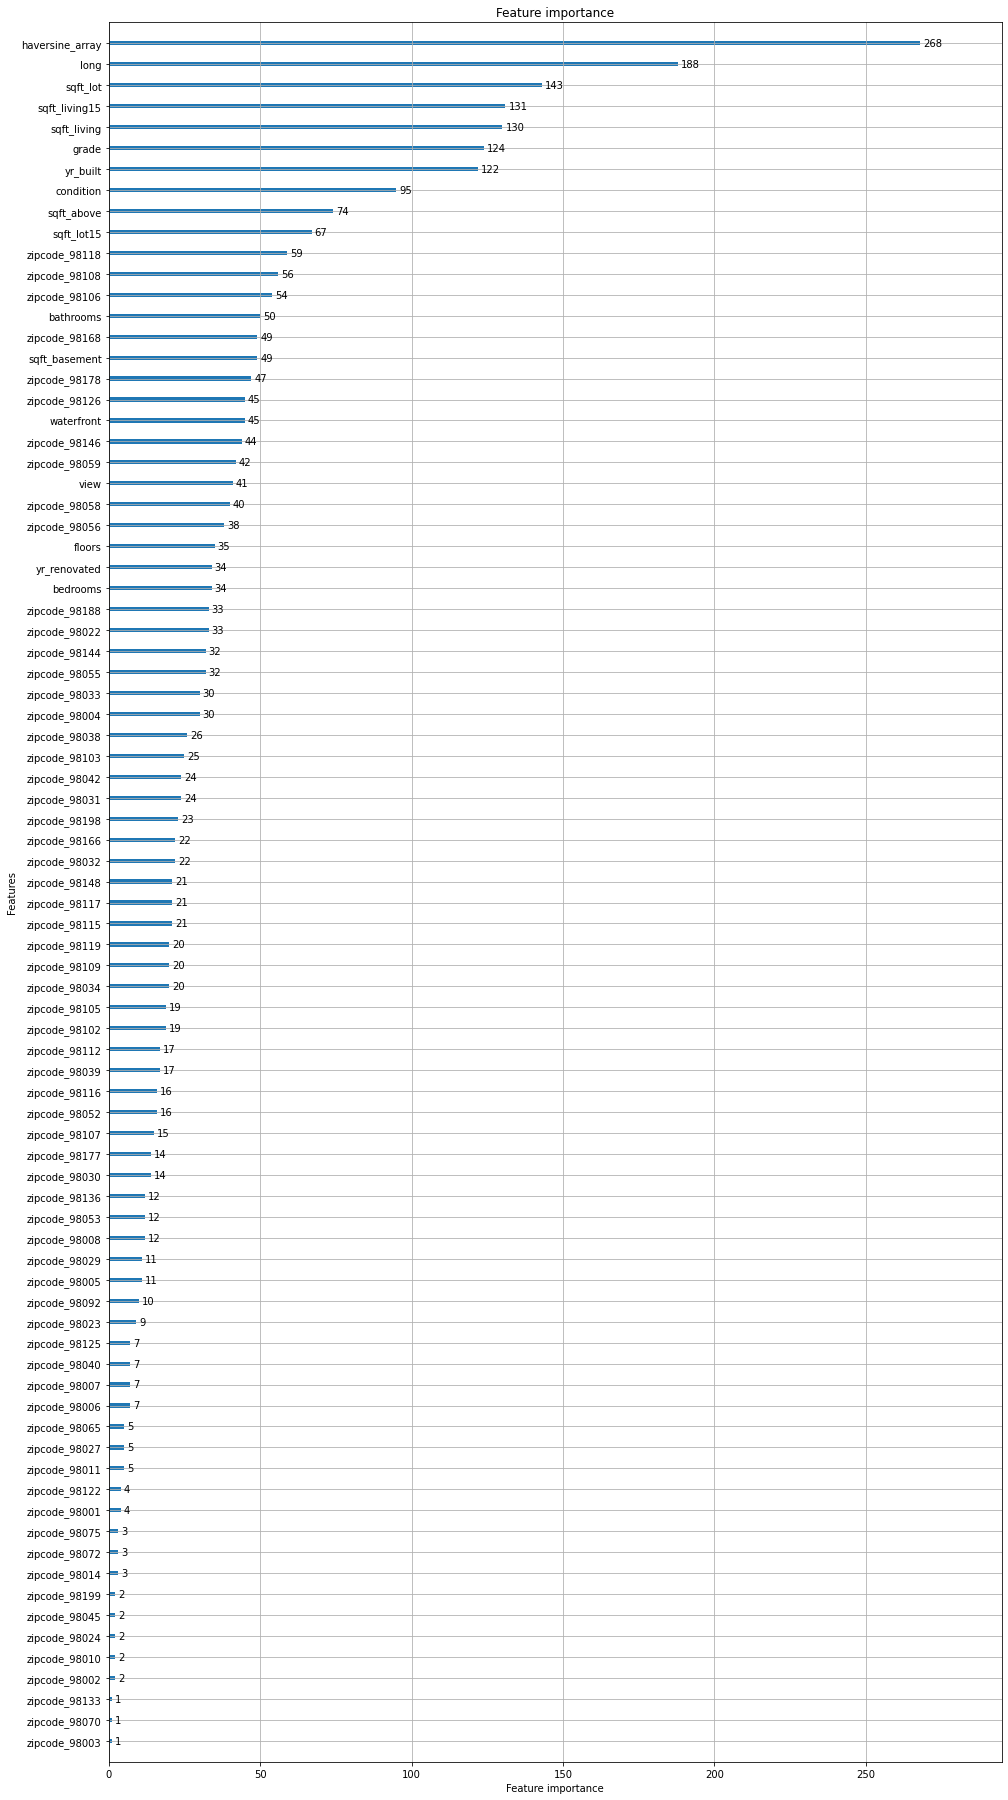

In [91]:
from lightgbm import plot_importance

plot_importance(lgb, figsize=(16, 32))
plt.show()